Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [X] Make at least 1 partial dependence plot to explain your model.
- [X] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [?] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction.
- [ ] If you log-transformed your regression target, then convert your PDP back to original units. 
- [ ] Use Plotly to make a 3D PDP.
- [X] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
import sys, getpass
a = getpass.getuser()
### example appending of folder
# A
sys.path.append('/home/{}/Code/Github-Repos/BFLibrary/'.format(a))
# B
sys.path.append('/Users/{}/Programs/BFLibrary/'.format(a))
#from BFLibrary import ACompass, BWarp, CToolbox 
import AMap as am
import BCook as bc
import CTools as ct

In [2]:
import pandas as pd
pd.options.display.float_format = None
#df = pd.read_excel('~/Downloads/CoralBleaching.xlsm')
df = pd.read_excel('/home/{}/Code/ML/CoralBleaching.xlsm'.format(a))

In [3]:
target = 'BLEACHING_SEVERITY'

In [4]:
def wrangle(df):
    # Let's group by bleaching or not.
    df[target] = df[target].replace({
        'Low':1, 'HIGH':1, 'Medium':1, 'Severity Unknown':1,
        'No Bleaching':0})
    ### ID 29433 LAT is actually -10.269
    df['LAT'] = df['LAT'].replace({-10269:-10.269})
    features, num_feats, cat_feats = bc.allPantryFeatures(df)
    
    ### Drop some columns w/ almost no values
    df = bc.diceBadCols(df, features, percent=60)
    # Drop always unique ID
    df.drop('ID', axis=1, inplace=True)
    
    return df

In [5]:
df = wrangle(df)

In [6]:
# Split into train test and val by year.
test_mask = (df['YEAR'] > 2005)
val_mask = (
    (df['YEAR'] > 2003) &
    (df['YEAR'] <= 2005)
)
train_mask = (df['YEAR'] <= 2003)
# Assign masks
test = df[test_mask]
train = df[train_mask]
val = df[val_mask]

# Just to see if they are the right shapes.
print(train.shape, val.shape, test.shape,"\n",
      "Sum of shapes:", train.shape[0]+val.shape[0]+test.shape[0],"\n",
      "Total dataframe shape:", df.shape[0])

(4167, 14) (965, 14) (1058, 14) 
 Sum of shapes: 6190 
 Total dataframe shape: 6190


In [7]:
# Get features from train after I chopped em'
features, _, _ = bc.allPantryFeatures(train)
X_train = train[features].drop(target,axis=1)
y_train = train[target]
X_val = val[features].drop(target,axis=1)
y_val = val[target]

In [8]:
# Majority class baseline
y_train.value_counts(normalize=True)

1    0.75594
0    0.24406
Name: BLEACHING_SEVERITY, dtype: float64

# Modeling Time

In [11]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [9]:
'''import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
%%time

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=4)
)
pipeline.fit(X_train,y_train)'''

"import category_encoders as ce\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.metrics import classification_report\nfrom sklearn.metrics import roc_auc_score\n%%time\n\npipeline = make_pipeline(\n    ce.OrdinalEncoder(),\n    SimpleImputer(strategy='median'),\n    RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=4)\n)\npipeline.fit(X_train,y_train)"

LAT                0
LON                0
MONTH            865
YEAR               0
SEVERITY_CODE      0
REGION             0
SUBREGION          0
COUNTRY            0
LOCATION           0
DEPTH              0
REMARKS            0
SOURCE             0
COUNTRY_CODE       0
dtype: int64

In [30]:
from pdpbox.pdp import pdp_plot, pdp_isolate
from pdpbox import pdp

features, _, _ = bc.allPantryFeatures(X_train)
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)
X_encoded = X_encoded.fillna(0)
model = RandomForestClassifier(
    n_estimators=20, 
    random_state=4, 
    n_jobs=-1
)
model.fit(X_encoded,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=4, verbose=0,
                       warm_start=False)

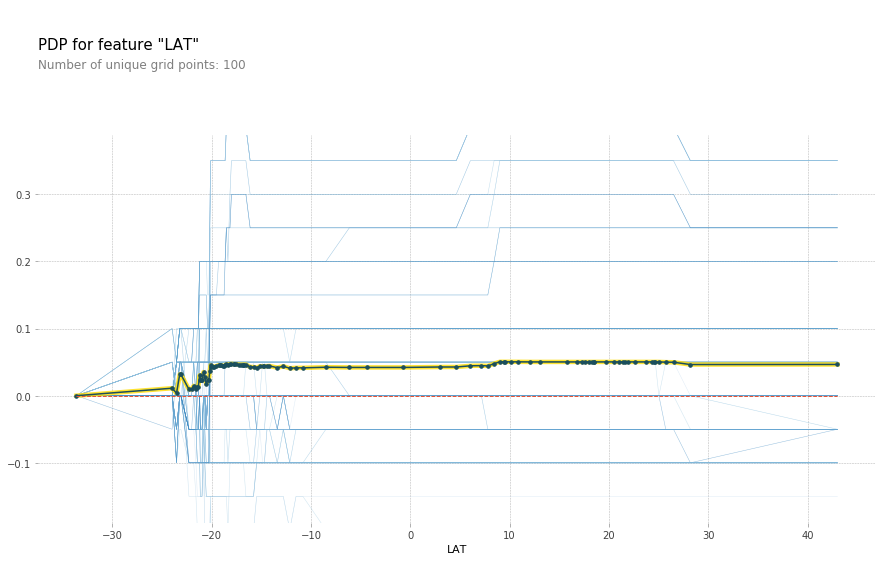

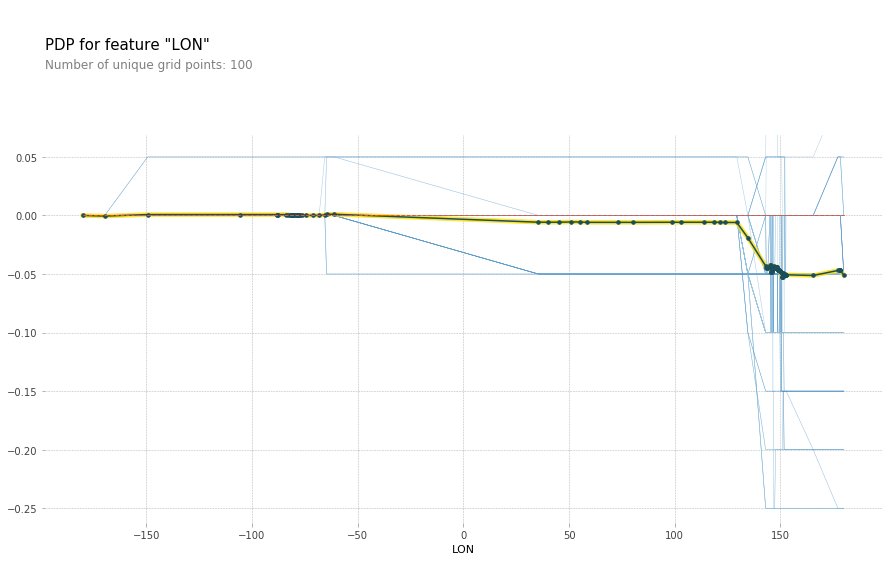

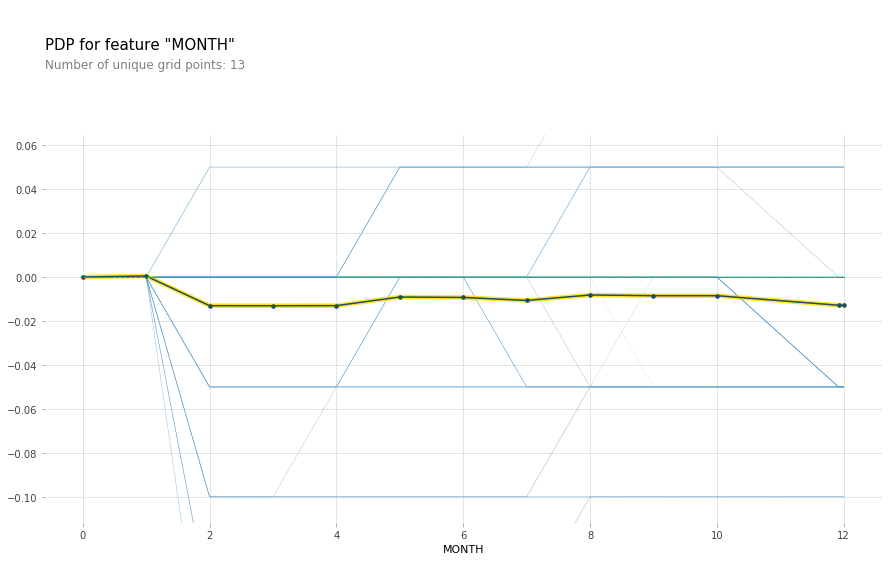

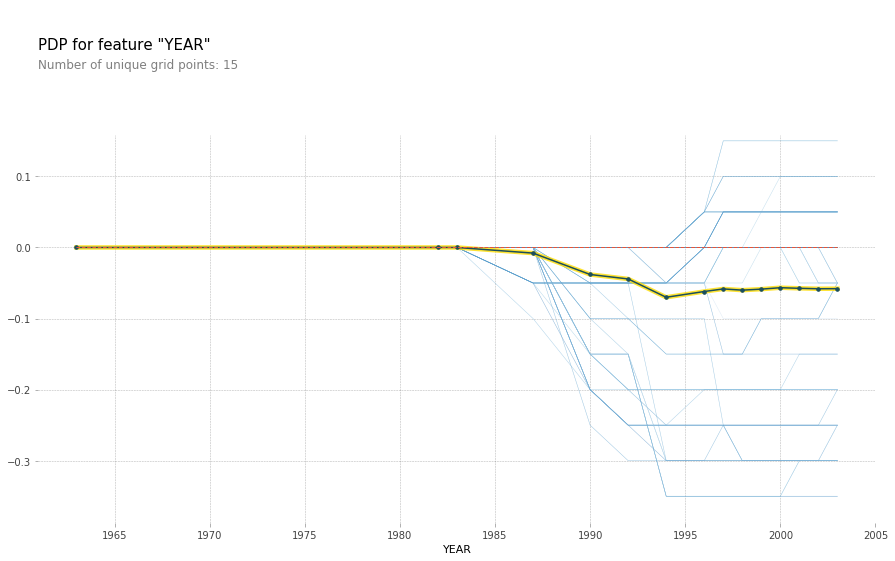

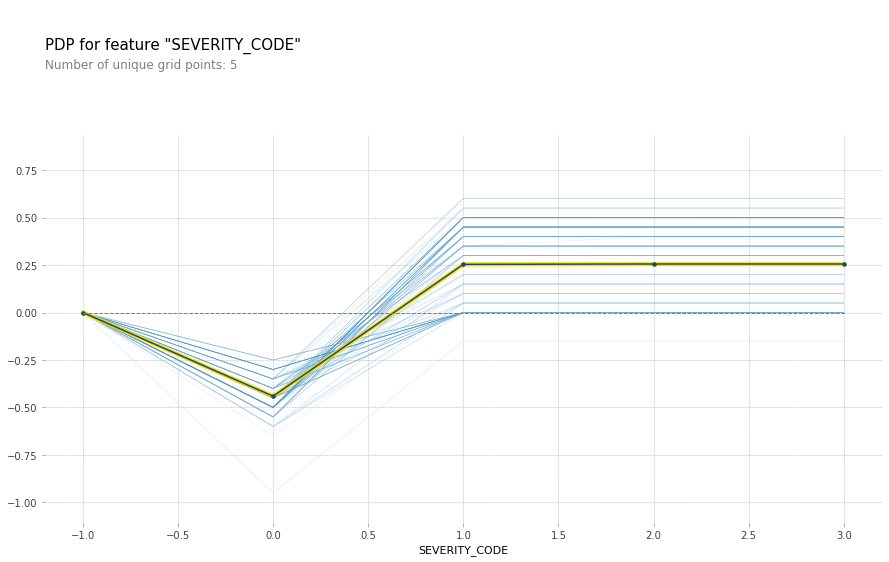

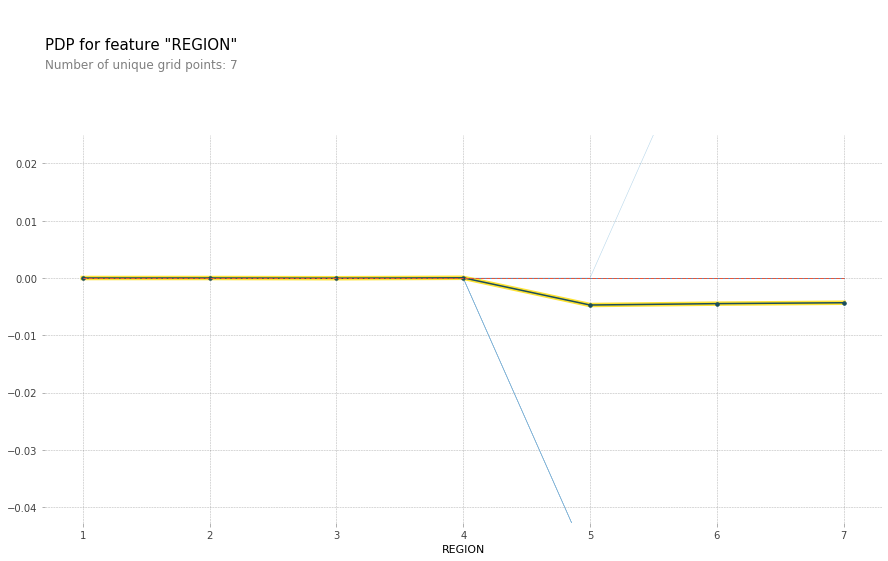

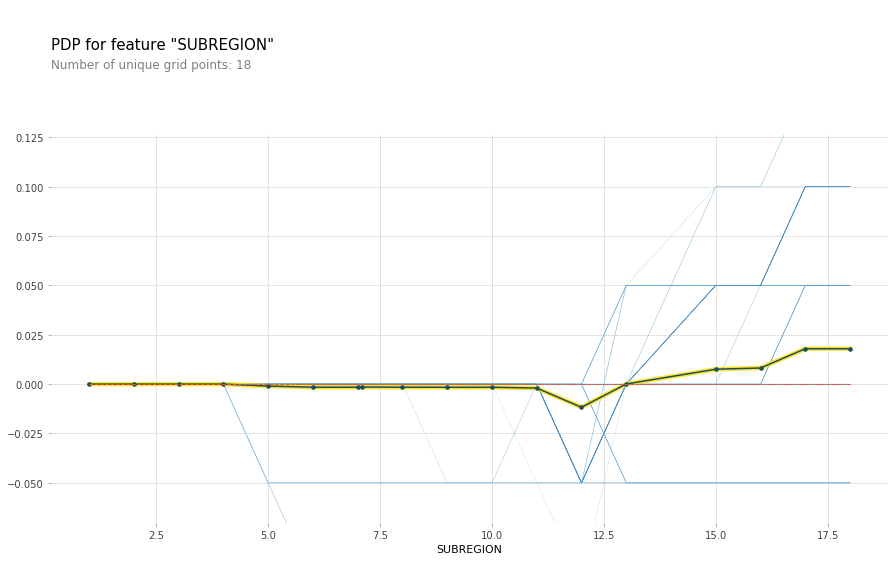

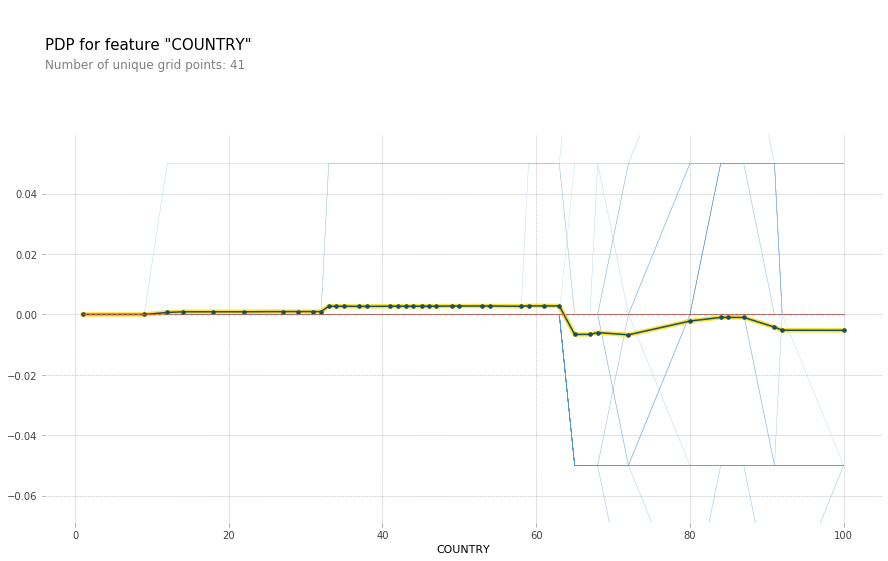

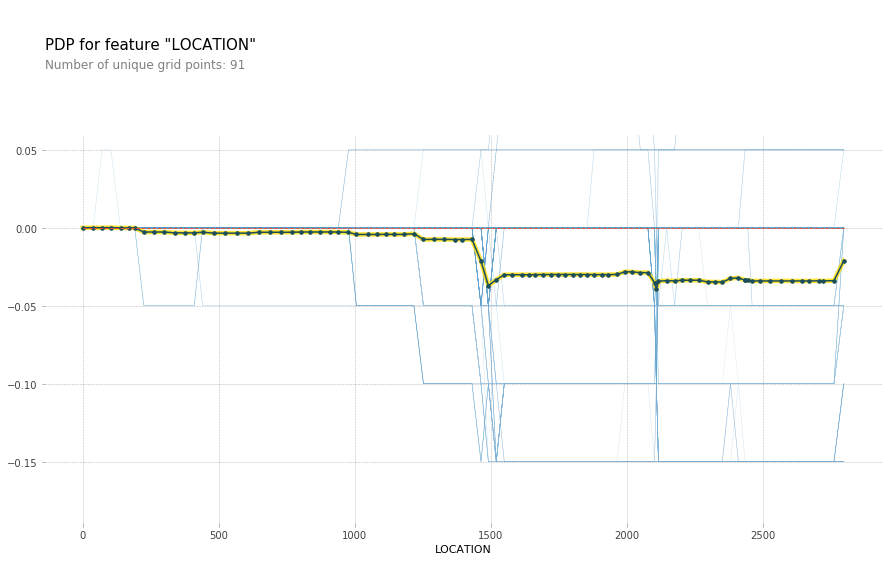

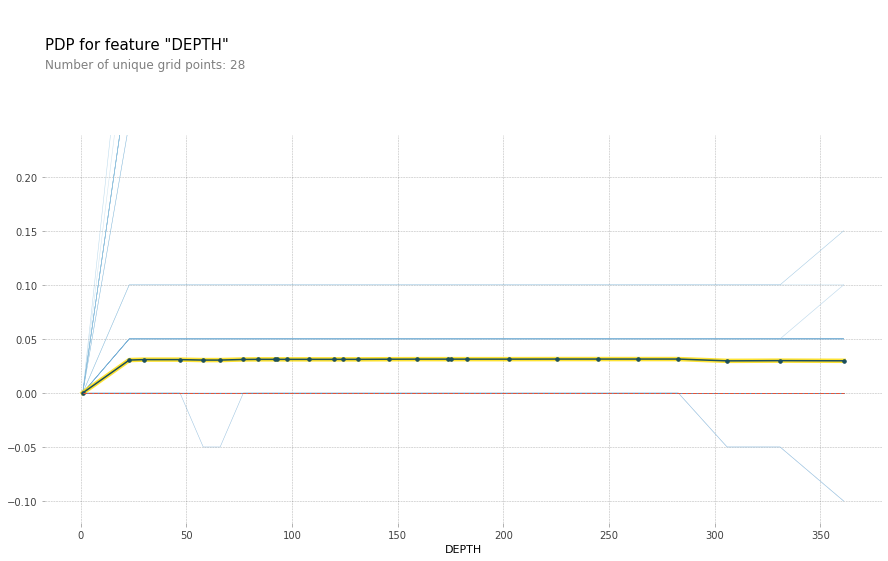

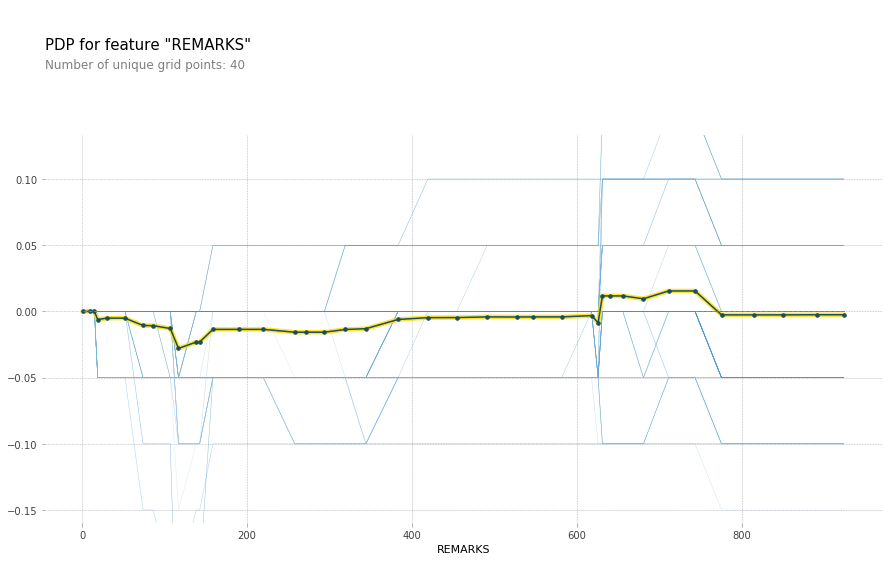

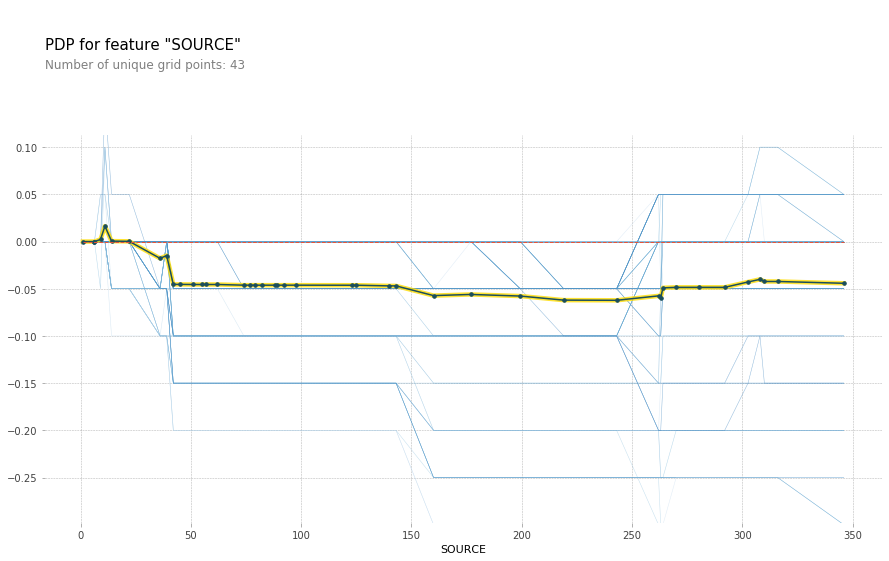

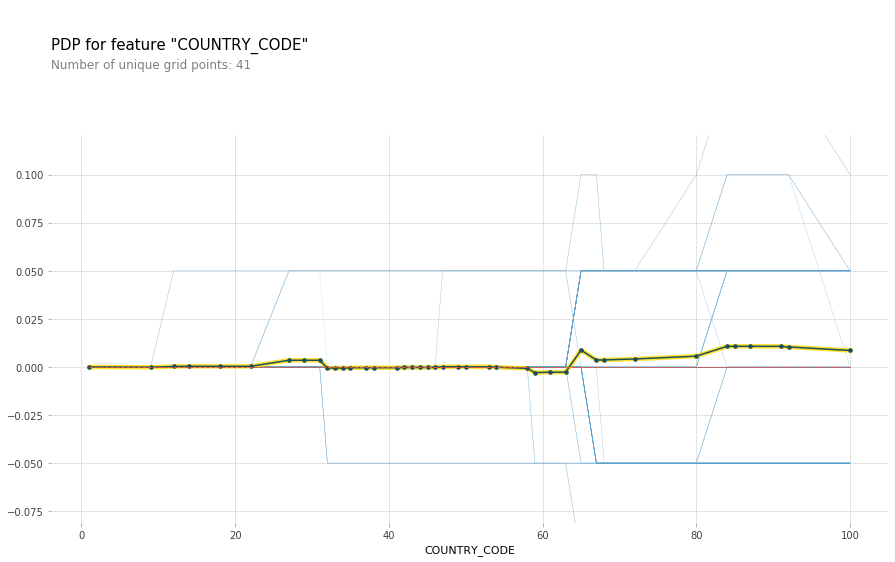

In [27]:
# using pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = features
for n in range(0, len(feature)):
    f = feature[n]
    pdp_dist = pdp.pdp_isolate(
        model=model, 
        dataset=X_encoded, 
        model_features=features, 
        feature=f,
        num_grid_points=100
    )
    
    pdp.pdp_plot(pdp_dist, feature_name=f, plot_lines=True, frac_to_plot=100);
    plt.show()
    

R^2 Score:0.9999999971260768
['LAT', 'LON', 'MONTH', 'YEAR', 'SEVERITY_CODE', 'REGION', 'SUBREGION', 'COUNTRY', 'LOCATION', 'DEPTH', 'REMARKS', 'SOURCE', 'COUNTRY_CODE']


(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7f91e7aa20>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7fb025d470>})

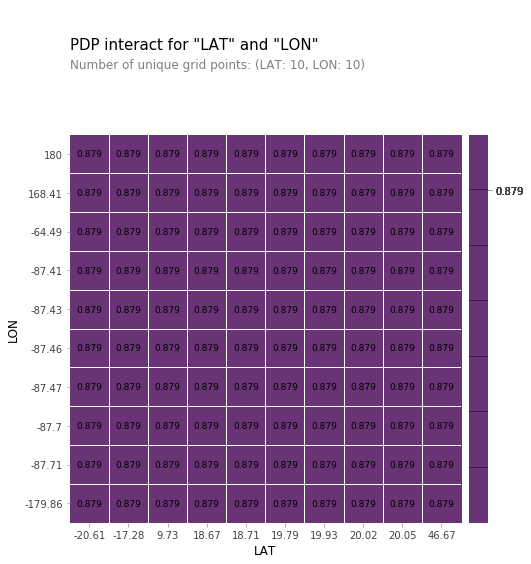

In [41]:
# Two dif functions
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(
        n_estimators=200,
        objective='reg:squarederror',
        n_jobs=-1
    )
)

gb.fit(X_train,y_train)
y_pred = gb.predict(X_val)

print("R^2 Score:{}".format(r2_score(y_val,y_pred)))

feature_lat_sev = feature

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features) # has to be grid instead of contour cause of bug

Clearly something off here lol. 

In [ ]:
'''y_pred = pipeline.predict(X_val)
accuracy_score(y_val,y_pred)
am.plotConfusionMatrix(y_val,y_pred)'''

In [ ]:
'''print(classification_report(y_val,y_pred))
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)'''